In [1]:
import os, sys, math, random, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models, utils
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import json, os
import shutil
print('Torch version:', torch.__version__)

Torch version: 2.8.0+cu126


## 2. Loading Dataset and Resnet18 Model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_dir = '/kaggle/working/data'
trainset = CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
testset  = CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader  = DataLoader(testset,  batch_size=128, shuffle=False, num_workers=2)

classes = trainset.classes
print('Classes:', classes)

Using device: cpu


100%|██████████| 170M/170M [00:02<00:00, 84.0MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
model = resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

try:
    from torchsummary import summary
    summary(model, (3,32,32))
except Exception as e:
    print('torchsummary not available or failed:', e)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 89.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [4]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total, correct = 0, 0
    for inputs, targets in tqdm(loader, desc='Train'):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*inputs.size(0)
        _,pred = outputs.max(1)
        total += targets.size(0)
        correct += pred.eq(targets).sum().item()
    return running_loss/total, correct/total

def test_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc='Test'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()*inputs.size(0)
            _,pred = outputs.max(1)
            total += targets.size(0)
            correct += pred.eq(targets).sum().item()
    return running_loss/total, correct/total

run_finetune = True
if run_finetune:
    epochs = 10
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, trainloader, optimizer, criterion, device)
        test_loss, test_acc = test_model(model, testloader, criterion, device)
        print(f'Epoch {epoch+1}/{epochs} - Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')


Test: 100%|██████████| 79/79 [00:25<00:00,  3.14it/s]


Epoch 1/10 - Train acc: 0.5357, Test acc: 0.6594


Test: 100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


Epoch 2/10 - Train acc: 0.6864, Test acc: 0.7185


Test: 100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Epoch 3/10 - Train acc: 0.7300, Test acc: 0.7532


Test: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


Epoch 4/10 - Train acc: 0.7550, Test acc: 0.7670


Test: 100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


Epoch 5/10 - Train acc: 0.7771, Test acc: 0.7859


Test: 100%|██████████| 79/79 [00:25<00:00,  3.14it/s]


Epoch 6/10 - Train acc: 0.7898, Test acc: 0.7935


Test: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]


Epoch 7/10 - Train acc: 0.7989, Test acc: 0.8065


Test: 100%|██████████| 79/79 [00:25<00:00,  3.15it/s]


Epoch 8/10 - Train acc: 0.8130, Test acc: 0.8048


Test: 100%|██████████| 79/79 [00:24<00:00,  3.22it/s]


Epoch 9/10 - Train acc: 0.8201, Test acc: 0.8115


Test: 100%|██████████| 79/79 [00:24<00:00,  3.19it/s]

Epoch 10/10 - Train acc: 0.8291, Test acc: 0.8178


## 3. Adversarial Attacks (FGSM and PGD attacks)

In [5]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_images = images + epsilon*sign_data_grad
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images.detach()


def pgd_attack(model, images, labels, epsilon=0.03, alpha=0.01, iters=40):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.data
    perturbed = images.clone().detach()
    perturbed.requires_grad = True
    for i in range(iters):
        outputs = model(perturbed)
        loss = criterion(outputs, labels)
        model.zero_grad(); loss.backward()
        adv_grad = perturbed.grad.data
        perturbed = perturbed + alpha * adv_grad.sign()
        eta = torch.clamp(perturbed - ori_images, min=-epsilon, max=epsilon)
        perturbed = torch.clamp(ori_images + eta, 0, 1).detach_()
        perturbed.requires_grad = True
    return perturbed.detach()


## 4. Evaluate model on clean and adversarial examples (batch-wise)

In [6]:
def evaluate_on_adversarial(model, loader, attack_fn, attack_params):
    model.eval()
    total, correct = 0, 0
    examples = []
    for inputs, targets in tqdm(loader, desc='Adv Eval'):
        inputs, targets = inputs.to(device), targets.to(device)
        adv_inputs = attack_fn(model, inputs, targets, **attack_params)
        outputs = model(adv_inputs)
        _,pred = outputs.max(1)
        total += targets.size(0)
        correct += pred.eq(targets).sum().item()
        if len(examples) < 8:
            for i in range(min(8 - len(examples), inputs.size(0))):
                examples.append((inputs[i].cpu(), adv_inputs[i].cpu(), targets[i].cpu(), pred[i].cpu()))
    return correct/total, examples

epsilon = 0.03
acc_clean = test_model(model, testloader, criterion, device)[1]
acc_fgsm, fgsm_examples = evaluate_on_adversarial(model, testloader, fgsm_attack, {'epsilon': epsilon})
acc_pgd, pgd_examples = evaluate_on_adversarial(model, testloader, pgd_attack, {'epsilon': epsilon, 'alpha':0.01, 'iters':10})
print('Clean accuracy (approx):', acc_clean)
print(f'FGSM (eps={epsilon}) accuracy:', acc_fgsm)
print(f'PGD  (eps={epsilon}) accuracy:', acc_pgd)


Adv Eval: 100%|██████████| 79/79 [19:02<00:00, 14.46s/it]

Clean accuracy (approx): 0.8178
FGSM (eps=0.03) accuracy: 0.1123
PGD  (eps=0.03) accuracy: 0.0007


## 5. Visualize original vs adversarial images and perturbations

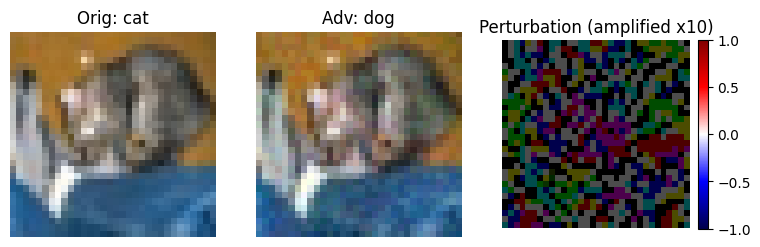

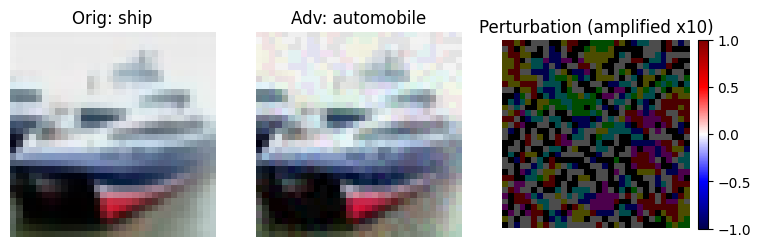

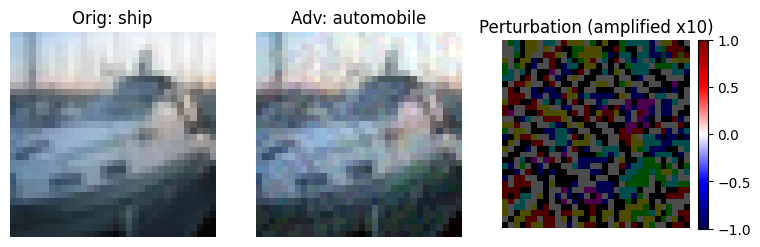

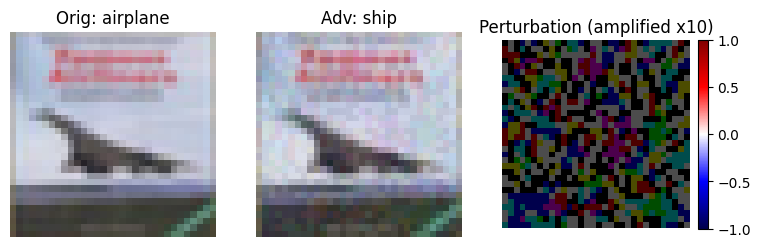

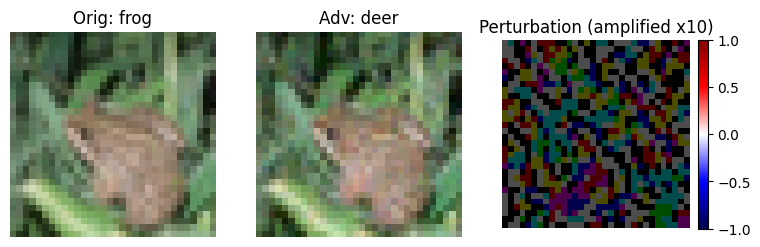

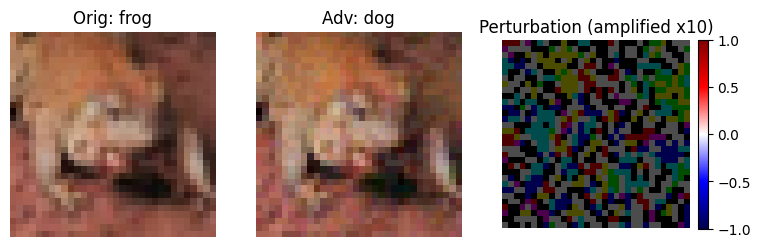

In [7]:
def imshow(img, title=''):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.title(title)

if 'fgsm_examples' in globals() and len(fgsm_examples) > 0:
    for idx, (orig, adv, label, pred) in enumerate(fgsm_examples[:6]):
        diff = adv - orig

        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1)
        imshow(orig, title=f'Orig: {classes[label]}')

        plt.subplot(1,3,2)
        imshow(adv, title=f'Adv: {classes[pred]}')

        plt.subplot(1,3,3)
        plt.title('Perturbation (amplified x10)')
        plt.axis('off')
        diff_np = diff.numpy().transpose(1,2,0) * 10
        plt.imshow(diff_np, cmap="seismic", vmin=-1, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)

        plt.show()


## 6. Train the model with FGSM examples on-the-fly to improve robustness.

In [ ]:
def train_epoch_adv(model, loader, optimizer, criterion, epsilon):
    model.train()
    total_loss = 0.0
    total, correct = 0, 0
    for inputs, targets in tqdm(loader, desc='AdvTrain'):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs_adv = fgsm_attack(model, inputs, targets, epsilon)
        inputs_combined = inputs_adv
        optimizer.zero_grad()
        outputs = model(inputs_combined)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*inputs.size(0)
        _,pred = outputs.max(1)
        total += targets.size(0)
        correct += pred.eq(targets).sum().item()
    return total_loss/total, correct/total

run_adv_train = True
if run_adv_train:
    adv_epochs = 5
    eps = 0.03
    for e in range(adv_epochs):
        loss, acc = train_epoch_adv(model, trainloader, optimizer, criterion, eps)
        val_loss, val_acc = test_model(model, testloader, criterion, device)
        print(f'AdvEpoch {e+1}/{adv_epochs} - Train acc: {acc:.4f}, Val acc: {val_acc:.4f}')


Test: 100%|██████████| 79/79 [00:25<00:00,  3.15it/s]


AdvEpoch 1/5 - Train acc: 0.2955, Val acc: 0.6692


Test: 100%|██████████| 79/79 [00:25<00:00,  3.11it/s]


AdvEpoch 2/5 - Train acc: 0.3065, Val acc: 0.6505


Test: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]


AdvEpoch 3/5 - Train acc: 0.3070, Val acc: 0.6396


Test: 100%|██████████| 79/79 [00:25<00:00,  3.16it/s]


AdvEpoch 4/5 - Train acc: 0.3090, Val acc: 0.6189


AdvTrain:  57%|█████▋    | 221/391 [10:43<08:19,  2.94s/it]

## 7. Show how adversarial noise affects model explanations using Grad-CAM.

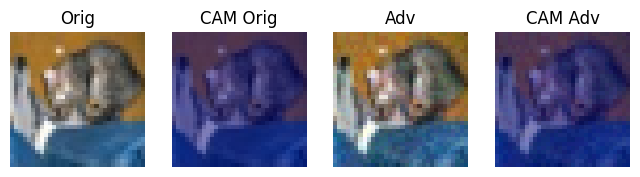

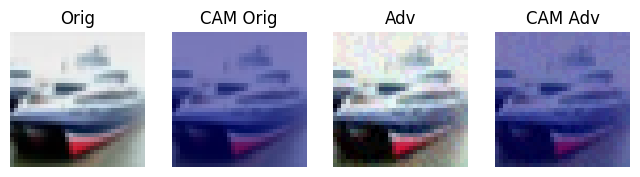

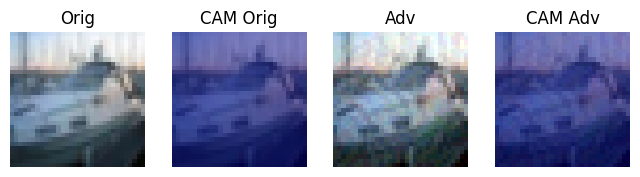

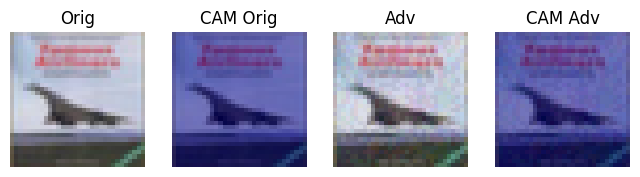

In [11]:
def overlay_cam_on_image(img, cam, alpha=0.5):
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    heatmap = plt.cm.jet(cam)[:, :, :3]
    overlay = alpha * heatmap + (1 - alpha) * img
    return np.clip(overlay, 0, 1)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        def save_grad(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        def save_act(module, input, output):
            self.activations = output.detach()
        target_layer.register_forward_hook(save_act)
        target_layer.register_backward_hook(save_grad)

    def __call__(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.unsqueeze(0).to(device)
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward(retain_graph=True)
        weights = self.gradients.mean(dim=(1,2), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(32,32), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

try:
    target_layer = model.layer4[1].conv2
    gcam = GradCAM(model, target_layer)
except Exception as e:
    print('GradCAM setup failed:', e)

if 'fgsm_examples' in globals() and len(fgsm_examples)>0:
    for i, (orig, adv, label, pred) in enumerate(fgsm_examples[:4]):
        cam_orig = gcam(orig, class_idx=label)
        cam_adv  = gcam(adv, class_idx=pred)
        plt.figure(figsize=(8,4))
        plt.subplot(1,4,1); plt.title('Orig'); plt.axis('off'); plt.imshow(np.transpose(orig.numpy(), (1,2,0)))
        plt.subplot(1,4,2); plt.title('CAM Orig'); plt.axis('off'); plt.imshow(overlay_cam_on_image(orig, cam_orig))
        plt.subplot(1,4,3); plt.title('Adv'); plt.axis('off'); plt.imshow(np.transpose(adv.numpy(), (1,2,0)))
        plt.subplot(1,4,4); plt.title('CAM Adv'); plt.axis('off'); plt.imshow(overlay_cam_on_image(adv, cam_adv))
        plt.show()


## 8. Reflections on Limitations and Practical Implications

### Limitations

**Attack Specificity**  
- The experiments primarily focused on **FGSM (Fast Gradient Sign Method)**, which is a relatively simple, single-step attack.  
- Stronger and iterative attacks like **PGD (Projected Gradient Descent)** or **CW (Carlini-Wagner)** could bypass the defense techniques more effectively.  

**Dataset & Model Constraints**  
- Experiments were carried out on a limited dataset (**CIFAR-10**) and a standard **ResNet-18**.  
- Results may not generalize to larger datasets (e.g., **ImageNet**) or more complex real-world architectures.  

**Defense Limitations**  
- Defensive methods such as **adversarial training** can improve robustness but often come at the cost of increased training time and reduced clean accuracy.  
- **Gradient masking** defenses may give a false sense of security, as adaptive attackers can still exploit the model.  

**Interpretability**  
- While **Grad-CAM** visualizations provide some insights into model focus, they may not always fully explain the decision-making process under adversarial perturbations.  

---

### Practical Implications

**Real-world Security Risks**  
- AI systems deployed in sensitive areas (e.g., **healthcare, finance, autonomous driving**) can be severely compromised by adversarial examples.  
- Even imperceptible perturbations can mislead models, highlighting the need for **robust defense mechanisms**.  

**Trade-off Between Robustness and Performance**  
- Enhancing robustness often reduces accuracy on clean inputs.  
- In practical deployment, one must balance between maintaining **model accuracy** and ensuring **resilience against adversarial attacks**.  

**Need for Continuous Monitoring**  
- Adversarial threats evolve, so defense strategies must be **continuously updated**.  
- **Security audits** and **adversarial robustness evaluation** should become a standard part of ML model deployment pipelines.  

**Ethical Considerations**  
- Understanding adversarial vulnerabilities is crucial not only for building robust AI but also to ensure **responsible and safe deployment**.  
- Ignoring adversarial robustness can lead to **misuse, safety hazards, and erosion of trust** in AI systems.  
